# Correlation Analysis Overview

This document outlines the analysis of **autocorrelation**, **cross-correlation**, and **Pearson correlation** in the dataset.

## Initial Analysis
We begin by examining the **Pearson correlation** to gain insights after an initial exploration of the data.

In [1]:
import pandas as pd
from IPython.display import display

df = pd.read_csv("weather_data.csv", parse_dates=["Date/Time"])

df["hour"] = df["Date/Time"].dt.hour
df["minute"] = df["Date/Time"].dt.minute
print(display(df.head(1)))

C:\Users\juliu\AppData\Local\Temp\ipykernel_27188\2383640046.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("weather_data.csv", parse_dates=["Date/Time"])


,Date/Time,PV3_C1_AI_P,WEATHER_STATION_AI_CONTROLWEB_BackofModuleTemperature1,WEATHER_STATION_AI_CONTROLWEB_BackofModuleTemperature2,WEATHER_STATION_AI_MGATE_AmbientTemperature,WEATHER_STATION_AI_MGATE_AmbientTemperaturewithOffset,WEATHER_STATION_AI_MGATE_DewpointValue,WEATHER_STATION_AI_MGATE_Humidity,WEATHER_STATION_AI_MGATE_HumidityOffset,WEATHER_STATION_AI_MGATE_HumiditywithOffset,WEATHER_STATION_AI_MGATE_Pyranometer1BodyTemperature,WEATHER_STATION_AI_MGATE_Pyranometer2BodyTemperature,WEATHER_STATION_AI_MGATE_SolarIrradiancePyranometer1,WEATHER_STATION_AI_MGATE_SolarIrradiancePyranometer2,WEATHER_STATION_AI_MGATE_TemperatureOffset,WEATHER_STATION_AI_MGATE_WindDirection,WEATHER_STATION_AI_MGATE_WindDirection_Out,WEATHER_STATION_AI_MGATE_WindSpeed,hour,minute
0,2025-05-04 23:40:01,0.0,39.625,2.6875,9.7,9.7,3.5,65.300003,0,65.300003,7.98,8.059999,-1.53,-1.47,0,331.700012,15,0.0,23,40


None


Overall Pearson correlation between power and SolarIrradiancePyranometer1: 0.992, p-value: 0.000e+00
The overall correlation is statistically significant.


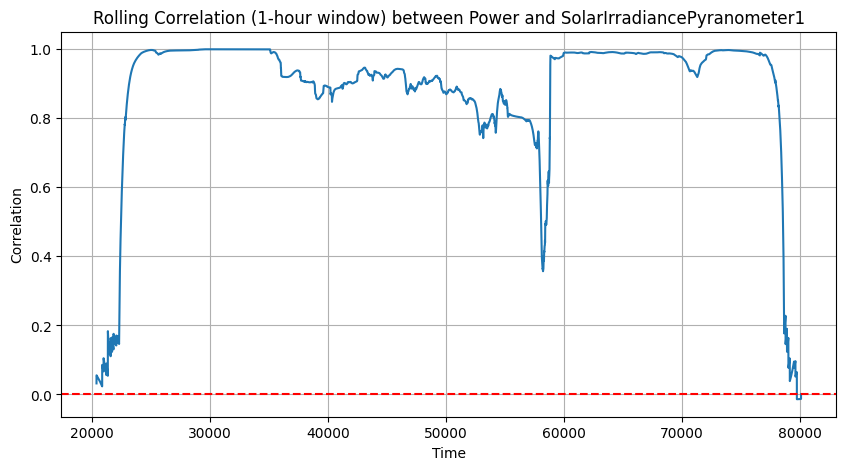

There are 1991 time points where the correlation is insignificant (|corr| < 0.1).
There are 35 time points where both power and SolarIrradiancePyranometer1 are zero (likely night).


In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Overall Pearson correlation
overall_corr, p_value = stats.pearsonr(df['PV3_C1_AI_P'], df['WEATHER_STATION_AI_MGATE_SolarIrradiancePyranometer1'])
print(f"Overall Pearson correlation between power and SolarIrradiancePyranometer1: {overall_corr:.3f}, p-value: {p_value:.3e}")
if p_value < 0.05:
    print("The overall correlation is statistically significant.")
else:
    print("The overall correlation is not statistically significant.")

# Rolling correlation (1-hour window = 3600 seconds)
window_size = 3600
rolling_corr = df['PV3_C1_AI_P'].rolling(window=window_size).corr(df['WEATHER_STATION_AI_MGATE_SolarIrradiancePyranometer1'])

# Plot rolling correlation
plt.figure(figsize=(10, 5))
rolling_corr.plot()
plt.title('Rolling Correlation (1-hour window) between Power and SolarIrradiancePyranometer1')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Identify periods where correlation is not significant
# For simplicity, consider correlation insignificant if |corr| < 0.1 (adjust threshold as needed)
insignificant_periods = rolling_corr[np.abs(rolling_corr) < 0.1]
if not insignificant_periods.empty:
    print(f"There are {len(insignificant_periods)} time points where the correlation is insignificant (|corr| < 0.1).")
else:
    print("There are no time points where the correlation is insignificant (|corr| < 0.1).")

# Optional: Check for periods where both features are zero (e.g., at night)
zero_both = df[(df['PV3_C1_AI_P'] == 0) & (df['WEATHER_STATION_AI_MGATE_SolarIrradiancePyranometer1'] == 0)]
if not zero_both.empty:
    print(f"There are {len(zero_both)} time points where both power and SolarIrradiancePyranometer1 are zero (likely night).")

## Autocorrelation

Next we show that there is significant **autocorrealtion** within both features

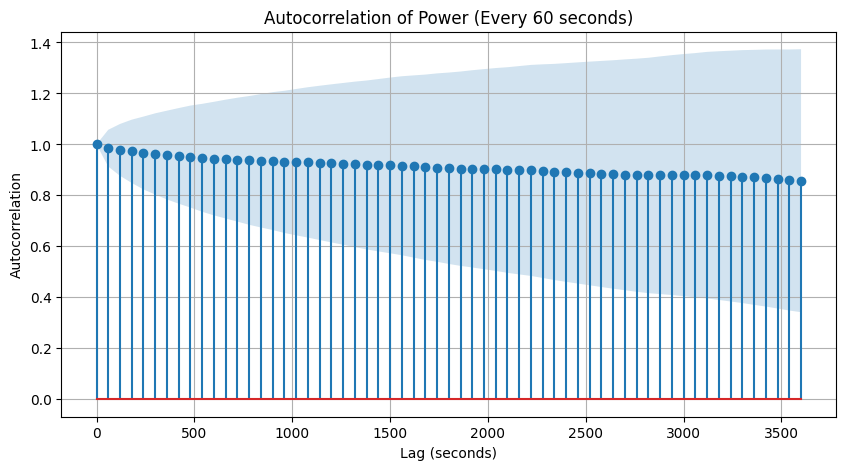

Power has 0 statistically significant lags (outside 95% CI).
Power has 61 practically significant lags (|ACF| > 0.5).


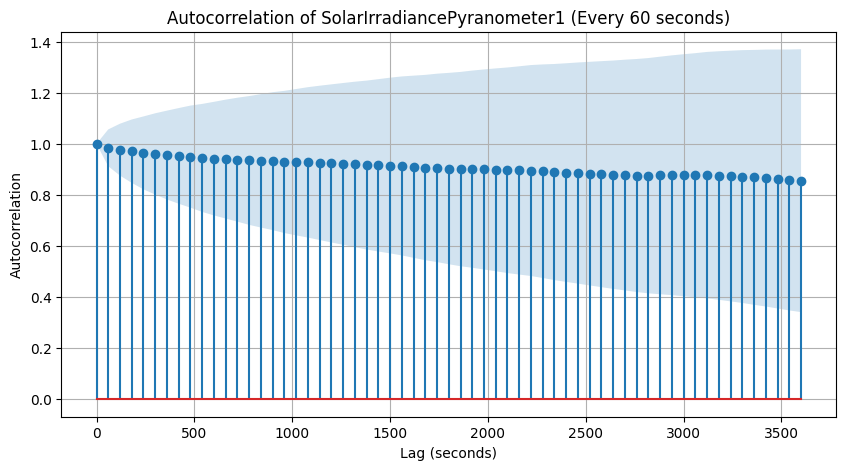

SolarIrradiancePyranometer1 has 0 statistically significant lags (outside 95% CI).
SolarIrradiancePyranometer1 has 61 practically significant lags (|ACF| > 0.5).


In [3]:
from statsmodels.tsa.stattools import acf

def compute_autocorrelation(series, lag_interval=60, max_lag=14400, title=''):
    # Compute ACF for all lags up to max_lag
    acf_vals, confint = acf(series, nlags=max_lag, fft=True, alpha=0.05)

    # Subsample lags (every lag_interval seconds)
    lags = np.arange(0, max_lag + 1, lag_interval)
    acf_vals_sub = acf_vals[::lag_interval]
    confint_sub = confint[::lag_interval]
    
    # Matplotlib Plot for quick visualization
    plt.figure(figsize=(10, 5))
    plt.stem(lags, acf_vals_sub)
    plt.fill_between(lags, confint_sub[:, 0], confint_sub[:, 1], alpha=0.2)
    plt.title(f'Autocorrelation of {title} (Every {lag_interval} seconds)')
    plt.xlabel('Lag (seconds)')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.show()
    
    # Check significant lags
    # significant_lags = np.where((acf_vals_sub > confint_sub[:, 1]) | (acf_vals_sub < confint_sub[:, 0]))[0]
    significant_lags = np.where((acf_vals_sub > confint_sub[:, 1]) | (acf_vals_sub < confint_sub[:, 0]))[0]
    practical_lags = np.where(np.abs(acf_vals_sub) > 0.5)[0]
    print(f"{title} has {len(significant_lags)} statistically significant lags (outside 95% CI).")
    print(f"{title} has {len(practical_lags)} practically significant lags (|ACF| > 0.5).")

    return lags, acf_vals_sub, confint_sub

# Compute autocorrelation
lags_power, acf_power, confint_power = compute_autocorrelation(
    df['PV3_C1_AI_P'], lag_interval=60, max_lag=3600, title='Power'
)
lags_irradiance, acf_irradiance, confint_irradiance = compute_autocorrelation(
    df['WEATHER_STATION_AI_MGATE_SolarIrradiancePyranometer1'], lag_interval=60, max_lag=3600, title='SolarIrradiancePyranometer1'
)

## Cross Correlation

To see whether Solar Irradiance has an impact on future power output we calculate the **ccf**.


Power vs SolarIrradiancePyranometer1 Cross-Correlation (Power vs Lagged SolarIrradiancePyranometer1):
Lag 0 seconds: CCF = 0.992, CI = [-0.007, 0.007]
Lag 5 seconds: CCF = 0.994, CI = [-0.007, 0.007]
Lag 10 seconds: CCF = 0.996, CI = [-0.007, 0.007]
Lag 15 seconds: CCF = 0.998, CI = [-0.007, 0.007]
Lag 20 seconds: CCF = 0.997, CI = [-0.007, 0.007]
Lag 25 seconds: CCF = 0.994, CI = [-0.007, 0.007]
Lag 30 seconds: CCF = 0.992, CI = [-0.007, 0.007]
Lag 35 seconds: CCF = 0.991, CI = [-0.007, 0.007]
Lag 40 seconds: CCF = 0.990, CI = [-0.007, 0.007]
Lag 45 seconds: CCF = 0.989, CI = [-0.007, 0.007]
Lag 50 seconds: CCF = 0.988, CI = [-0.007, 0.007]


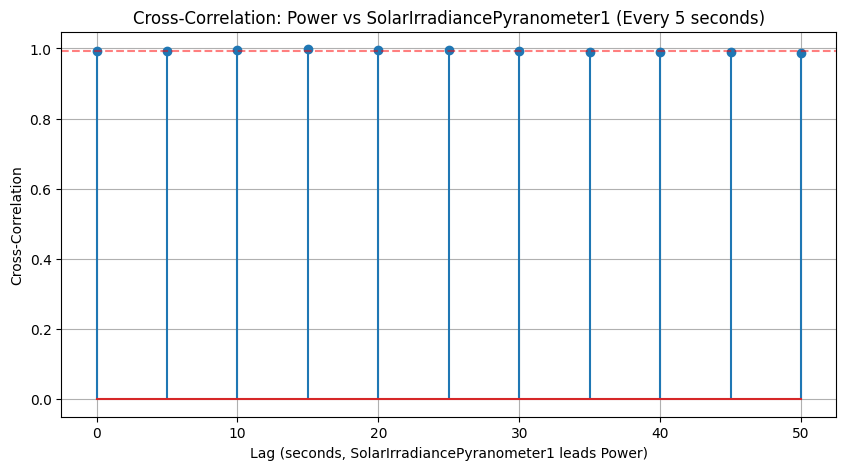

Power vs SolarIrradiancePyranometer1 has 11 statistically significant lags (|CCF| > 0.007).


In [4]:
from statsmodels.tsa.stattools import ccf

def compute_cross_correlation(series1, series2, lag_interval=60, max_lag=3600, title=''):

    ccf_vals = ccf(series1, series2, adjusted=True)[:max_lag + 1]
    
    if len(series1) >= 30:
    # Approximate 95% confidence interval
        ci = 1.96 / np.sqrt(len(series1))
    else:
        ci = 0.07

    lags = np.arange(0, max_lag + 1, lag_interval)
    ccf_vals_sub = ccf_vals[::lag_interval]
    
    # Print CCF at key lags
    print(f"\n{title} Cross-Correlation (Power vs Lagged SolarIrradiancePyranometer1):")
    for lag, ccf_val in zip(lags, ccf_vals_sub):
        print(f"Lag {lag} seconds: CCF = {ccf_val:.3f}, CI = [{-ci:.3f}, {ci:.3f}]")
    
    # Matplotlib Plot
    plt.figure(figsize=(10, 5))
    plt.stem(lags, ccf_vals_sub)
    # plt.axhline(y=ci, color='r', linestyle='--', alpha=0.5)
    plt.axhline(y=1-ci, color='r', linestyle='--', alpha=0.5)
    plt.title(f'Cross-Correlation: {title} (Every {lag_interval} seconds)')
    plt.xlabel('Lag (seconds, SolarIrradiancePyranometer1 leads Power)')
    plt.ylabel('Cross-Correlation')
    plt.grid(True)
    plt.show()
    
    # Check significant lags
    significant_lags = np.where(np.abs(ccf_vals_sub) > ci)[0]
    print(f"{title} has {len(significant_lags)} statistically significant lags (|CCF| > {ci:.3f}).")
    
    return lags, ccf_vals_sub, ci


lags_ccf, ccf_vals, ci = compute_cross_correlation(
    df['PV3_C1_AI_P'], df['WEATHER_STATION_AI_MGATE_SolarIrradiancePyranometer1'],
    lag_interval=5, max_lag=50, title='Power vs SolarIrradiancePyranometer1'
)
